In [1]:
# Clear Jupyter notebook output and clear all variables
from IPython.display import clear_output
clear_output(wait=True)

# Remove all user-defined variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]
# Set path to the parent directory
import sys
import os
file = "/home/ashwin/GIT/PulsarAnalyticsKit/"
sys.path.append(file)

# Import necessary modules
from core.pulsar_analysis import pulsar_analysis
from core.generic_plotting import *


In [2]:
import os
import psutil
import gc
import numpy as np  # For simulating memory usage

def memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss  # in bytes
    return mem / (1024 * 1024)       # convert to MB

print(f"🔍 Memory before allocation: {memory_usage():.2f} MB")

🔍 Memory before allocation: 182.17 MB


In [3]:
class pulsar_analysis(pulsar_analysis):
    def template(self):
        print("Template for pulsar analysis")




In [4]:
vela_long_data = "../Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt"
pulsar = pulsar_analysis(vela_long_data, channel_names=["N", "S"], data_type='ascii',block_size=512, avg_blocks=60, sample_rate=33e6)

Given Data is of ndim : 2 . shape : 2
file_path: ../Data4Analysis/ch00_B0833-45_20150612_191438_010_4.txt
data_type: ascii
n_channels: 2
raw_data shape :  (30719999, 2)
channel_names: ['N', 'S']
block_size: 512
avg_blocks: 60
sample_rate: 33000000.0
intensity_matrix_ch_s shape :  (2,)
dedispersed_ch_s shape :  (2,)
dedispersed_choped_ch_s: [None None]
folded_ch_s: [None None]
center_freq_MHZ: 326.5
bandwidth_MHZ: 16.5
skip_rows: 1
stokes_parameters shape :  (4,)
L: None
P_frac: None
PA: None


Stokes parameters calculated successfully


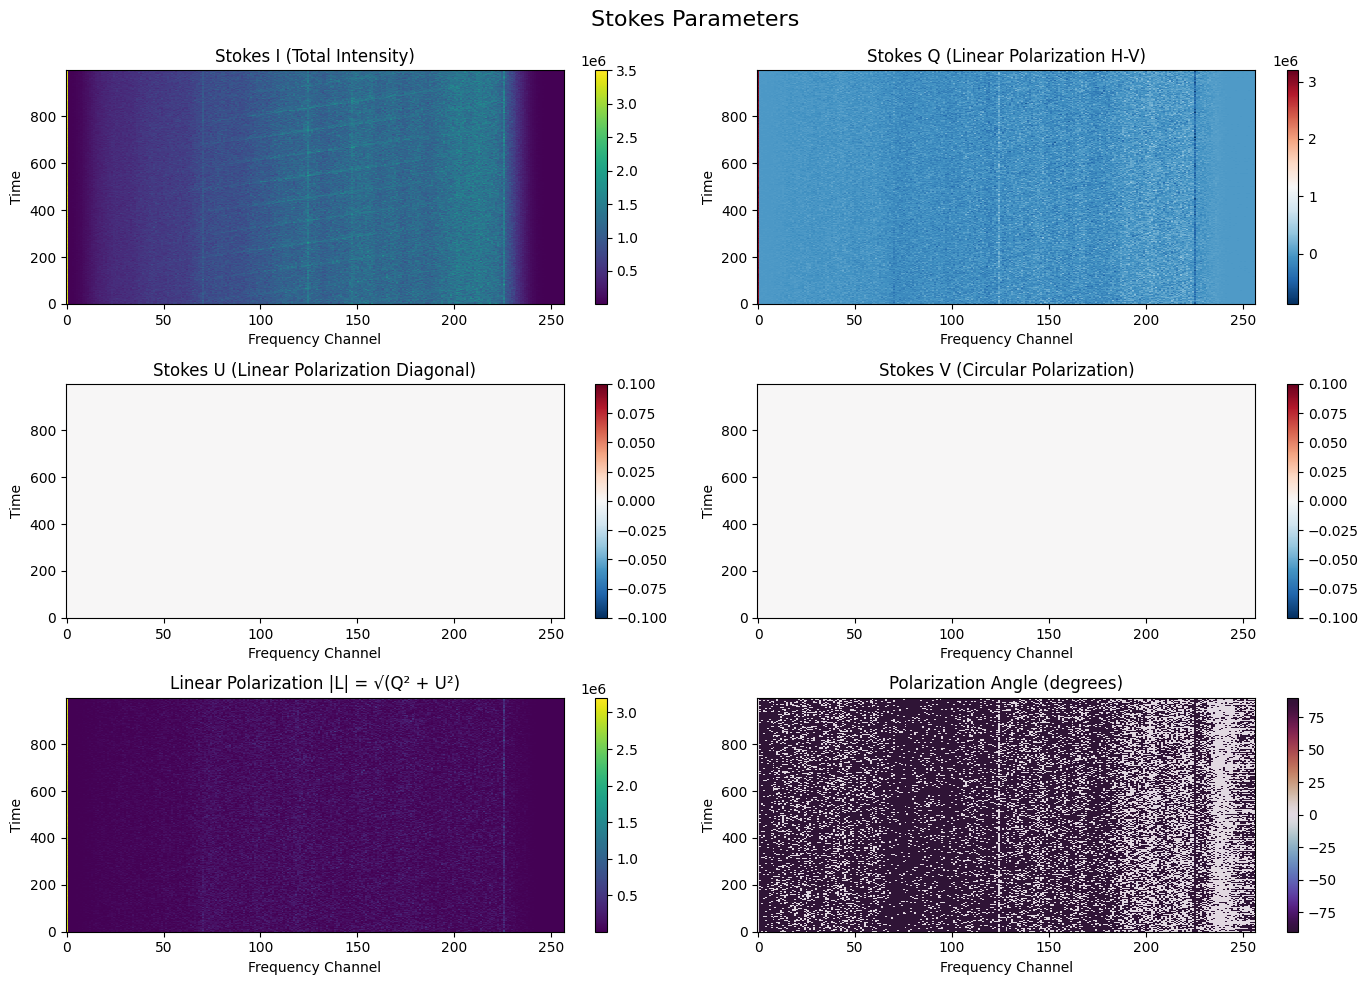

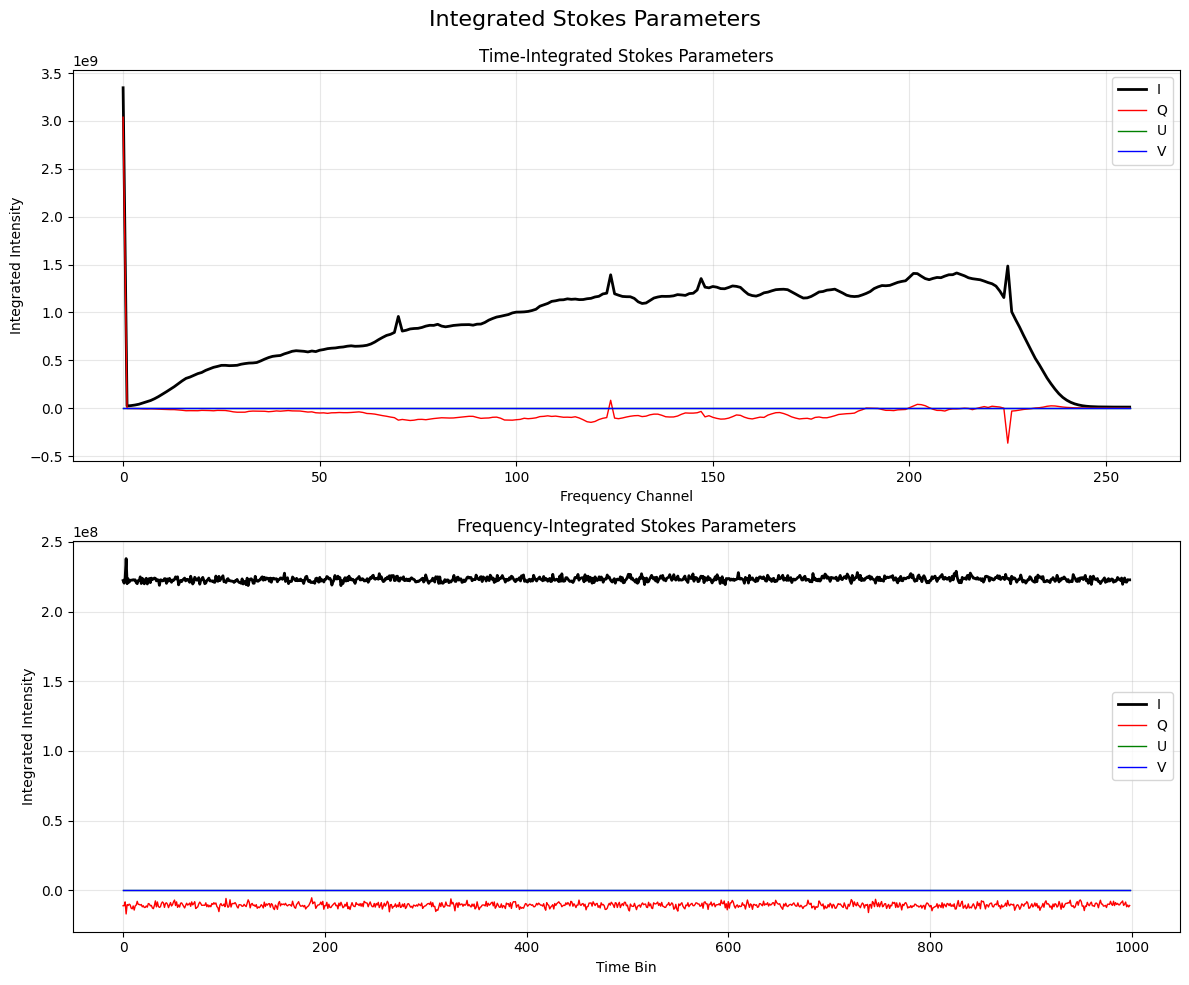

In [5]:
pulsar.compute_intensity_matrix()
# Calculate Stokes parameters
pulsar.calculate_stokes_parameters()

# Plot Stokes parameters
pulsar.plot_stokes_parameters()

# Plot integrated Stokes parameters
pulsar.plot_integrated_stokes()

In [6]:
percentofData = 50 # Percentage of data to analyze
n = int(pulsar.raw_data.shape[0] * percentofData / 100)

ch0 = pulsar.raw_data[:n , 0]
ch1 = pulsar.raw_data[:n, 1]
fs = pulsar.sample_rate

# compare_channels(ch0,ch1, fs, label="Comparision of N and S channels",)

del ch0, ch1, fs
gc.collect()

38569

/home/ashwin/GIT/PulsarAnalyticsKit/core/generic_plotting.py:169: UserWarning: nperseg=1024 is greater than signal length max(len(x), len(y)) = 1000, using nperseg = 1000
  f, Pxx = welch(ch, fs=sample_rate, nperseg=1024)


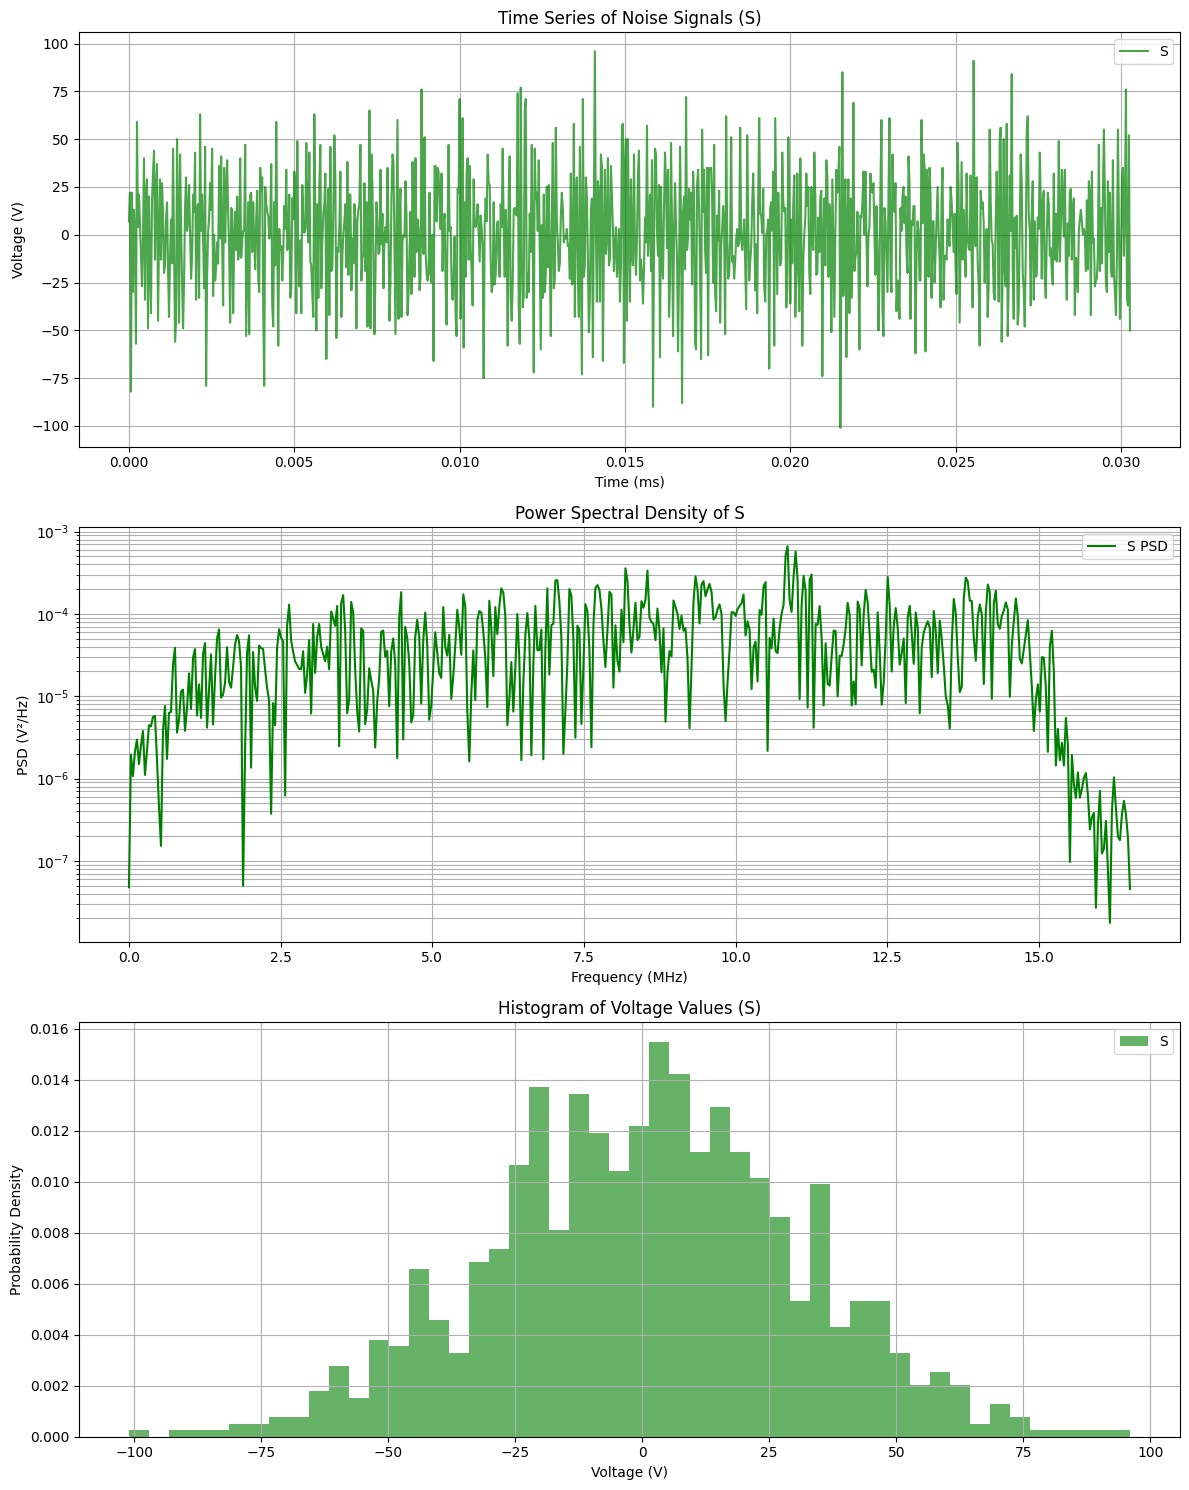

In [7]:

Plot_characterstics(pulsar,channel=1)

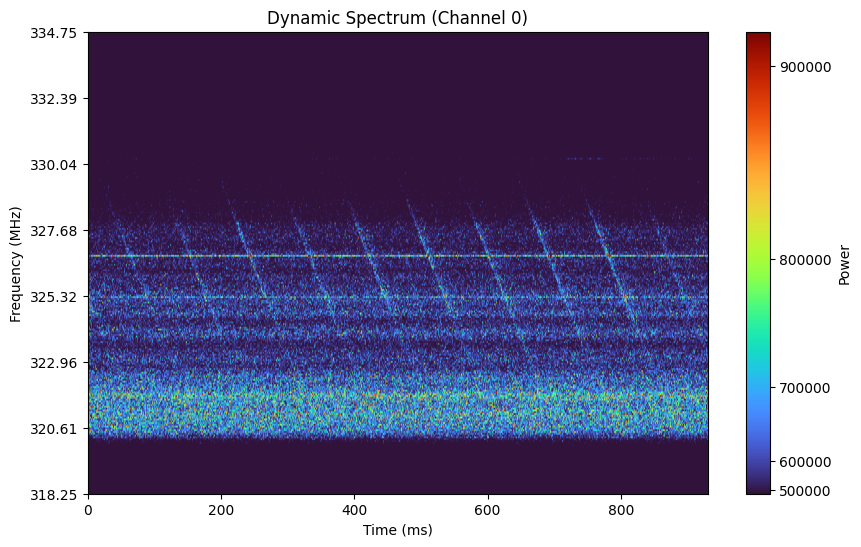

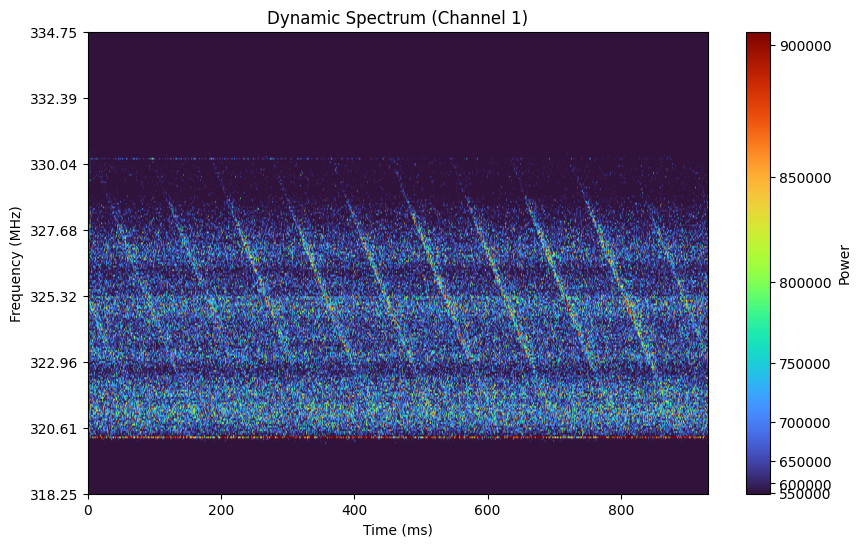

In [8]:
pulsar.compute_intensity_matrix()
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [9]:
import numpy as np

time_bin =  1/ pulsar.avg_blocks 

def channel_efficiency(matrix):
    """
    Compute efficiency for each frequency channel in the dynamic spectrum.

    Efficiency E = mean / (std * sqrt(TBP)) where TBP = number of time bins

    Args:
        matrix (2D numpy array): [time, frequency] intensity matrix

    Returns:
        1D numpy array of efficiencies for each frequency channel
    """
    n_time, n_freq = matrix.shape
    means = matrix.mean(axis=0)
    stds = matrix.std(axis=0)
    stds = np.where(stds == 0, 1, stds)  # Avoid division by zero

    TBP = 60
    efficiencies = means / (stds * np.sqrt(TBP))
    return efficiencies

def remove_rfi_by_efficiency(matrix, threshold=1 - 4 / np.sqrt(1024), fill_value=0, verbose=True):
    """
    Mask or replace RFI-affected frequency channels using efficiency threshold.

    Args:
        matrix (2D array): [time, frequency] intensity matrix
        threshold (float): Efficiency cutoff threshold (default = 1 - 4/√M where M=1024)
        fill_value: Value to replace RFI-affected channels with (e.g., np.nan or 0)
        verbose (bool): Whether to print removed channels info

    Returns:
        Cleaned 2D matrix
    """
    efficiency = channel_efficiency(matrix)
    bad_channels_up = efficiency < 1 - threshold
    bad_channels_down =efficiency > 1 + threshold
    bad_channels = np.logical_or(bad_channels_up, bad_channels_down)

    cleaned = matrix.copy()
    cleaned[:, bad_channels] = fill_value

    if verbose:
        print(f"Removed {np.sum(bad_channels)} RFI channels out of {matrix.shape[1]} using efficiency threshold {threshold:.4f}")
    return cleaned


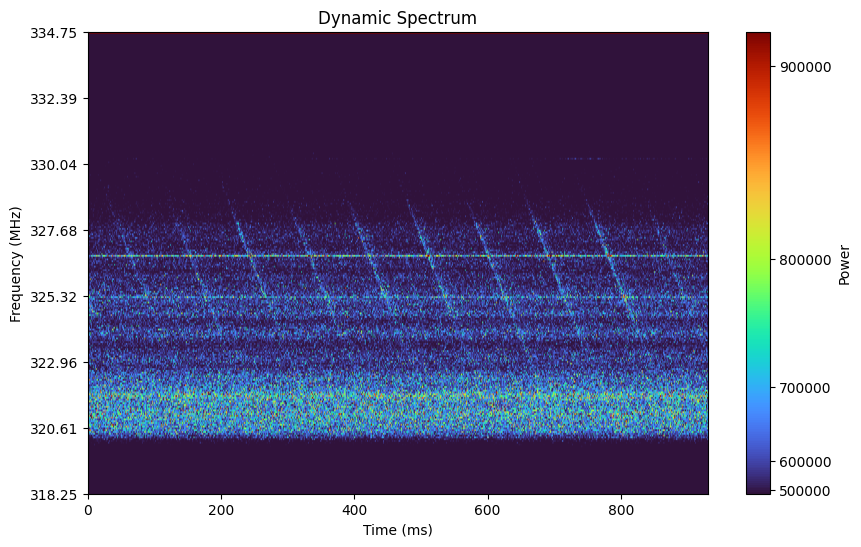

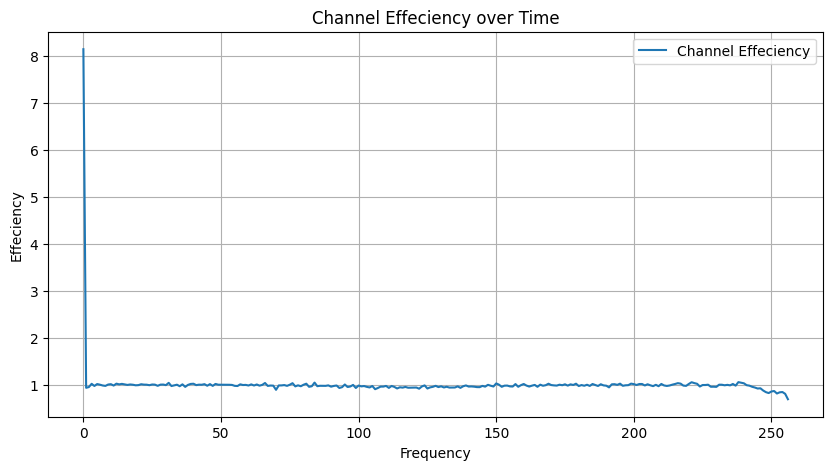

Removed 12 RFI channels out of 257 using efficiency threshold 0.1000


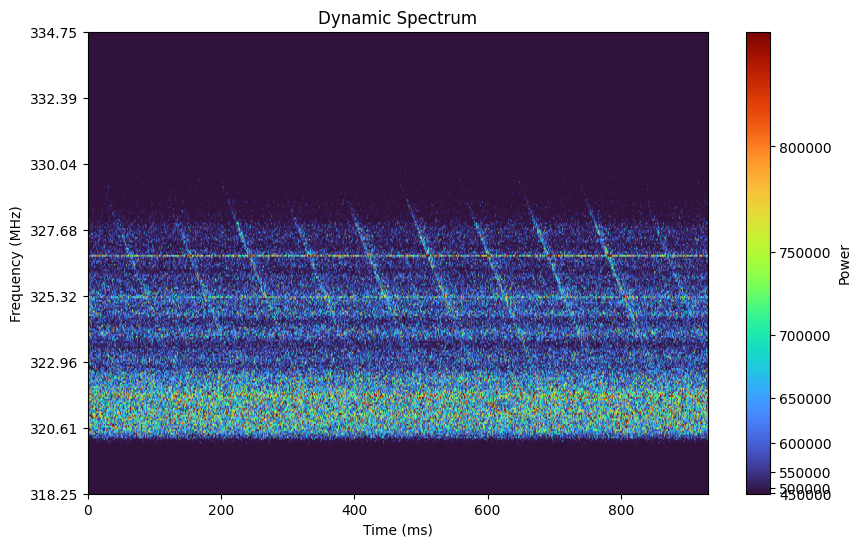

21610

In [10]:
matrix = pulsar.intensity_matrix_ch_s[0]
plot_intensity_matrix_single(matrix, pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)

effeciency = channel_efficiency(matrix)

# Plot the effeciency
plt.figure(figsize=(10, 5))     
plt.plot(effeciency, label='Channel Effeciency')
plt.xlabel('Frequency')
plt.ylabel('Effeciency')
plt.title('Channel Effeciency over Time')
plt.legend()
plt.grid()
plt.show()

plot_intensity_matrix_single(remove_rfi_by_efficiency(matrix,threshold = 0.1), pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5)

del matrix, effeciency
gc.collect()

Applying RFI mitigation...
Flagging 10 channels as RFI heavy
Flagging 1 channels as RFI heavy


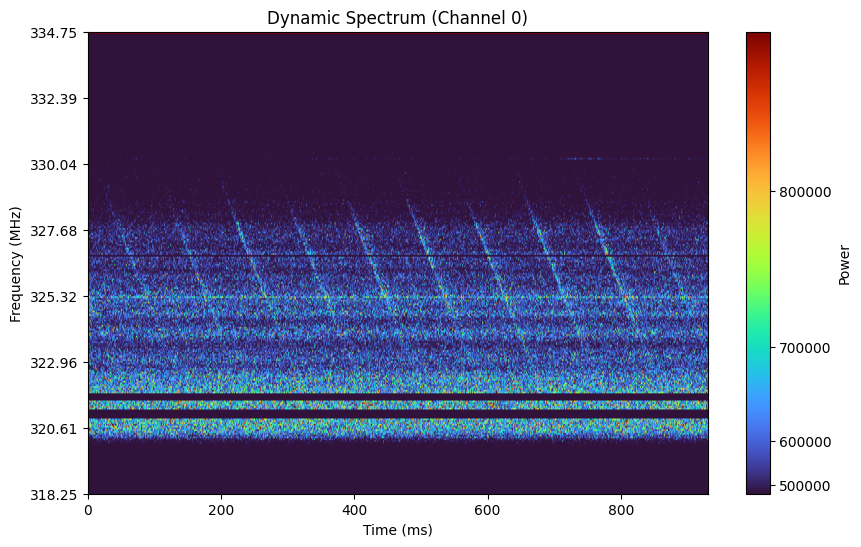

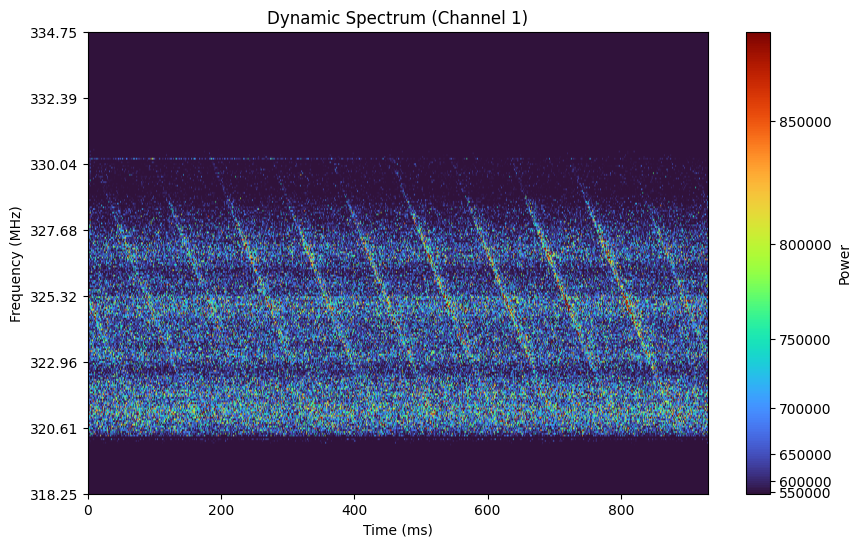

In [11]:
pulsar.compute_intensity_matrix()
pulsar.RFI_mitigation(freq_ch_std_threshold=1,freq_ch_mean_threshold=1,time_ch_threshold=7,fill_value=0)
plot_intensity_matrix(pulsar,channel = 0)
plot_intensity_matrix(pulsar,channel = 1)

In [12]:
from core.functions import *

In [13]:
def fold_matrix(matrix, period_ms, block_size, avg_blocks , sample_rate):
    
    t_bin =  avg_blocks * block_size / sample_rate * 1000 # in mili Sec
    delay_bins = int(period_ms / t_bin)
    print(delay_bins)

    n_time, n_freq = matrix.shape
    print(matrix.shape)

    reshaped = np.zeros(( delay_bins,n_freq))  # Initialize reshaped with a dummy value
    print(reshaped.shape)
    
    i = 0
    while i < n_time / delay_bins - 1 :
        reshaped = reshaped + matrix[int(i*delay_bins):int((i+1)*delay_bins) , :]  # Reshape the matrix
        i += 1
    return reshaped / i



Gaussian fit maximum at DM = 69.82461, Score = 2833518.01524


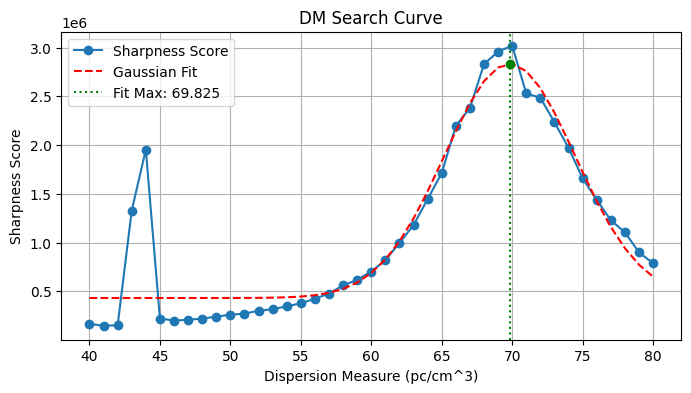

In [14]:


dm_min, dm_max,tol = 40,80,1
pulsar.pulseperiod_ms = 89.33
scores = pulsar.Auto_dedisperse(channel=1,num_peaks=10,to_plot=0,dm_min=dm_min, dm_max=dm_max,tol=tol)
plot_dm_curve(np.array(scores)[:,0], np.array(scores)[:,1])




In [15]:
DM = 69.82
pulsar.dedispersion_measure = DM

pulsar.Manual_dedisperse_pop(DM = DM,channel = "all")



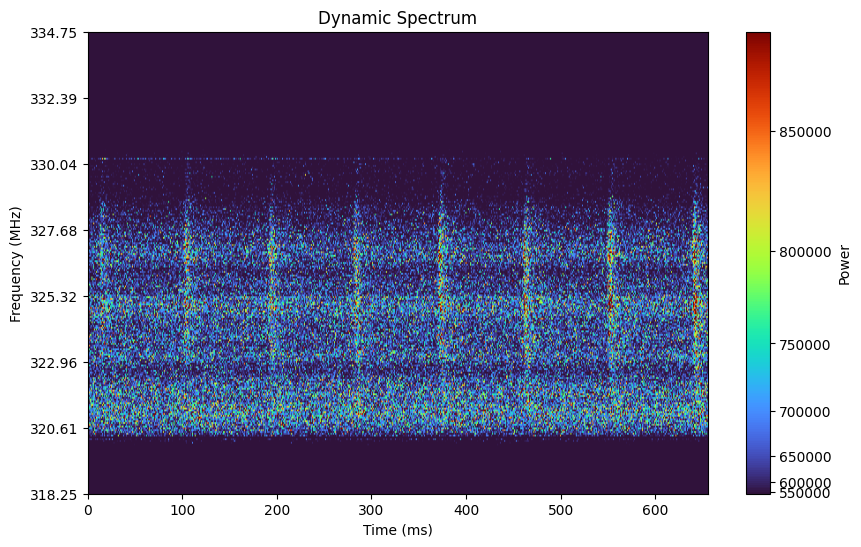

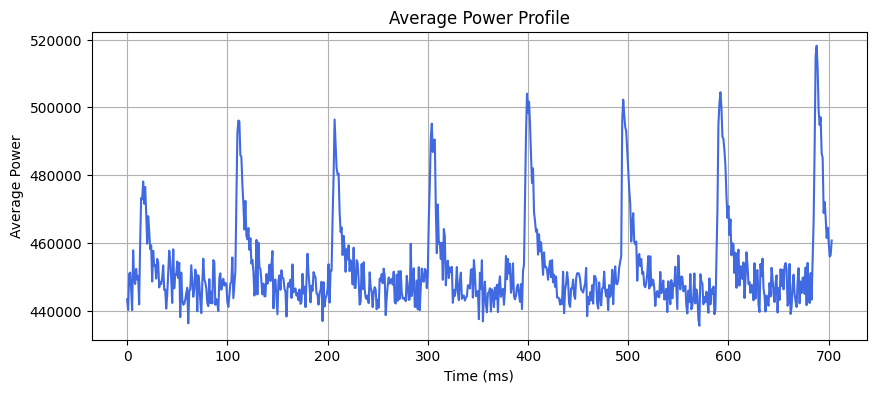

95
(704, 257)
(95, 257)


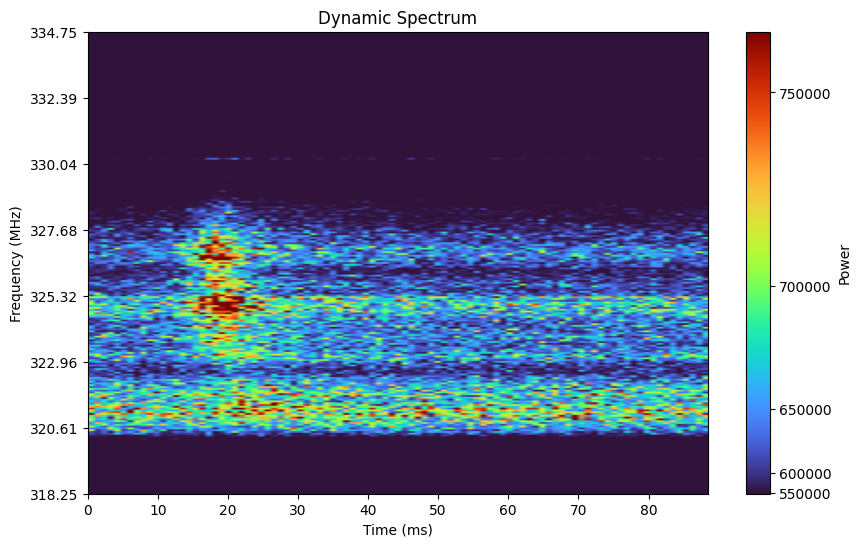

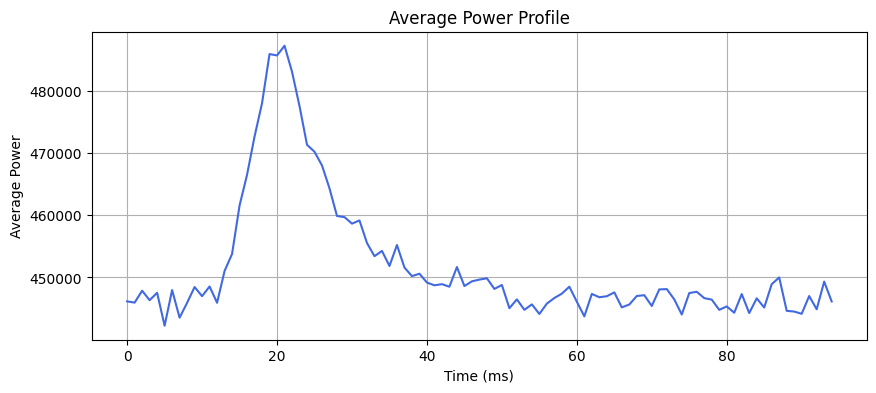

In [16]:
matrix = pulsar.dedispersed_choped_ch_s[1]
block_size, avg_blocks , sample_rate = pulsar.block_size, pulsar.avg_blocks, pulsar.sample_rate

plot_intensity_matrix_single(matrix, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5,power_profile=True)
period_ms = 89.33 
folded = fold_matrix(matrix, period_ms, block_size, avg_blocks , sample_rate)
plot_intensity_matrix_single(folded, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5,power_profile=True)

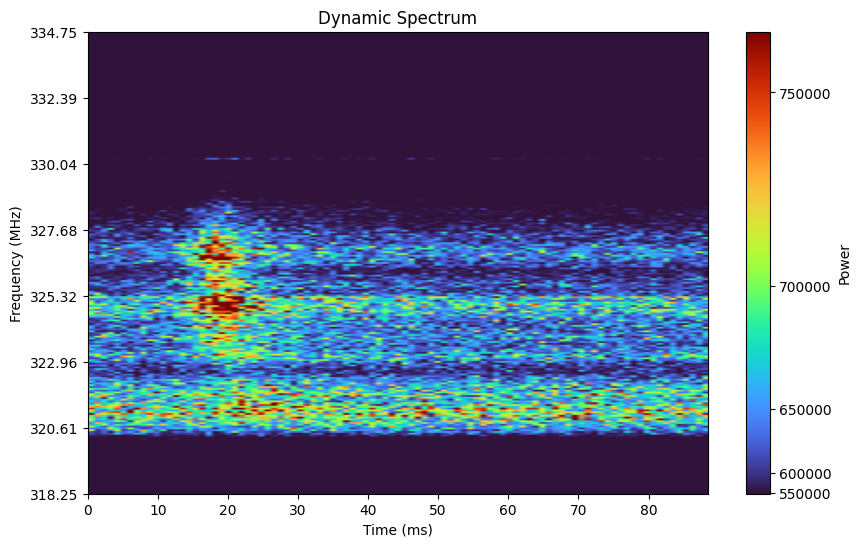

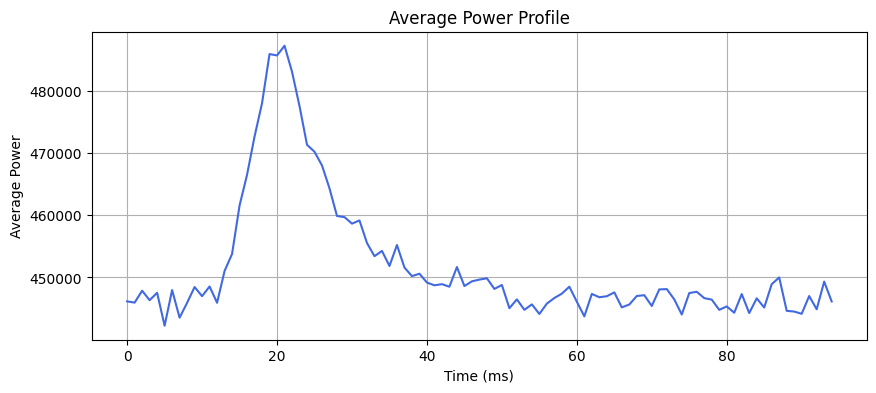

In [17]:
plot_intensity_matrix_single(folded, block_size, avg_blocks, sample_rate, pulsar.bandwidth_MHZ, pulsar.center_freq_MHZ, gamma=2.5, power_profile=True)

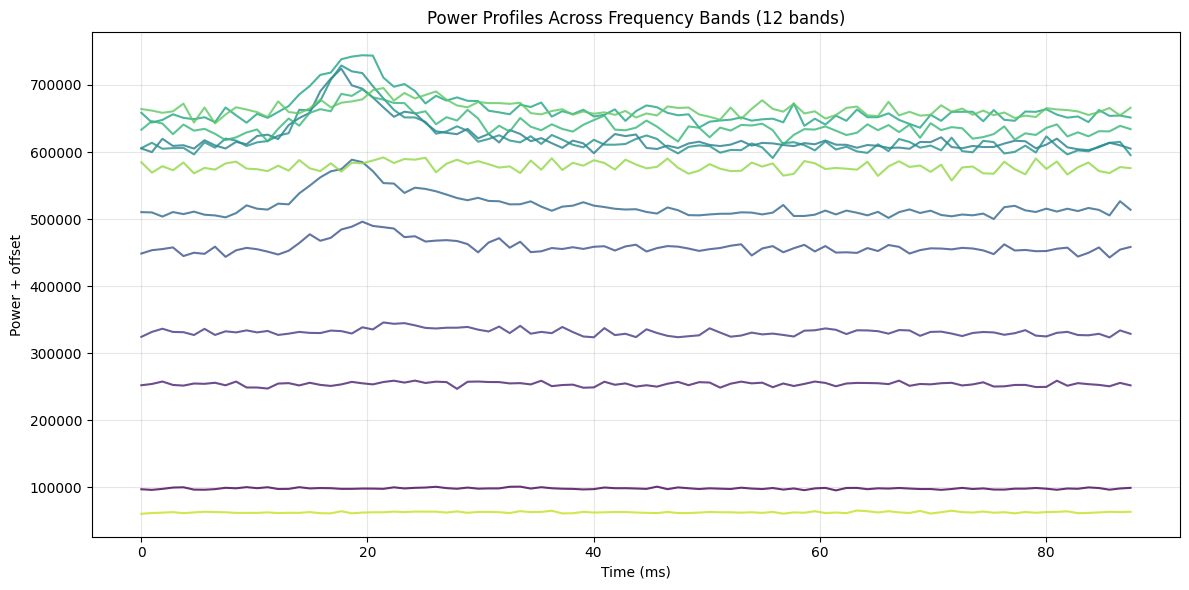

In [18]:

plot_power_profiles_by_band(
    matrix=folded,
    center_freq_MHZ=pulsar.center_freq_MHZ,
    bandwidth_MHZ=pulsar.bandwidth_MHZ,
    num_bands=12,  # Try 10–15
    sample_rate=sample_rate,
    block_size=block_size,
    avg_blocks=avg_blocks
)


In [19]:
def plot_power_profiles_lines(matrix, center_freq_MHZ=326.5, bandwidth_MHZ=16.5, 
                             num_bands=10, sample_rate=33e6, block_size=512, avg_blocks=60):
    """
    Plot power profiles for each frequency band as lines over time.
    """
    num_segments, n_freq = matrix.shape
    time_bin_us = (block_size * avg_blocks / sample_rate) * 1e6
    time_axis_ms = np.arange(num_segments) * time_bin_us / 1000

    # Frequency axis
    freq_array = np.linspace(center_freq_MHZ + bandwidth_MHZ / 2,
                             center_freq_MHZ - bandwidth_MHZ / 2, n_freq)

    band_size = n_freq // num_bands
    Freqs = []
    for i in range(num_bands):
        start = i * band_size
        end = n_freq if i == num_bands - 1 else (i + 1) * band_size
        band_data = matrix[:, start:end]
        power_profile = np.mean(band_data, axis=1)
        plt.plot(time_axis_ms, np.log10(power_profile + 1), label=f"{np.mean(freq_array[start:end]):.2f} MHz")
        Freqs.append(np.mean(freq_array[start:end]))

    plt.xlabel("Time (ms)")
    plt.ylabel("Log Power")
    plt.title("Power Profiles Across Frequency Bands")
    plt.legend(title="Band Center Freq")
    plt.grid()
    plt.tight_layout()
    plt.show()


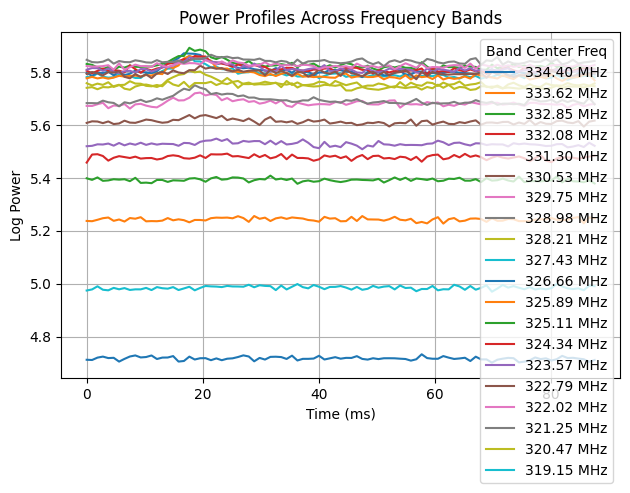

In [20]:
plot_power_profiles_lines(matrix=folded,
    center_freq_MHZ=pulsar.center_freq_MHZ,
    bandwidth_MHZ=pulsar.bandwidth_MHZ,
    num_bands=20,
    sample_rate=sample_rate,
    block_size=block_size,
    avg_blocks=avg_blocks)

In [21]:
# import os
# import psutil
# import gc
# import numpy as np  # For simulating memory usage

# def memory_usage():
#     process = psutil.Process(os.getpid())
#     mem = process.memory_info().rss  # in bytes
#     return mem / (1024 * 1024)       # convert to MB

# print(f"🔍 Memory before allocation: {memory_usage():.2f} MB")



# gc.collect()

# print(f"🧹 Memory after cleanup: {memory_usage():.2f} MB")

# del pulsar, ch0, ch1, fs, matrix, effeciency
# gc.collect()
# print(f"🧹 Memory after cleanup: {memory_usage():.2f} MB")

